In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
from pathlib import Path
import os
sys.path.append('../../')

In [3]:
ROOT = "/Users/louislacombe/Thesis_code/yolov5"
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative


LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
WORLD_SIZE = int(os.getenv('WORLD_SIZE', 1))

In [4]:
import yaml
import datetime
from tqdm import tqdm
from argparse import Namespace
import argparse
import json

import numpy as np
import torch

from utils.general import split_dict

from utils.calibration_utils import (
    setup_data_model, get_yolo_predictions, get_data_pred, calib_prep, collect_data_obj, 
    fitting_obj_calibrators, predict_obj_conf, draw_reliability_graph, 
    create_pred_for_nms, NMS, calibration,
    collect_data_class, fitting_class_calibrators, predict_class_conf,
    )

from sklearn.isotonic import IsotonicRegression


/Users/louislacombe/opt/anaconda3/envs/yolov5_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Calibration

In [6]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.metrics import box_iou
from matplotlib.offsetbox import TextArea, AnnotationBbox

from argparse import Namespace
import yaml
from pathlib import Path
from sklearn.base import clone
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import _SigmoidCalibration
import pickle
import torch

from models.common import DetectMultiBackend
from utils.general import (LOGGER, check_dataset, xywh2xyxy, Profile, check_img_size, colorstr, scale_boxes, non_max_suppression)
from utils.torch_utils import select_device
from utils.dataloaders import create_dataloader
from utils.metrics import ap_per_class, ConfusionMatrix
from val import process_batch

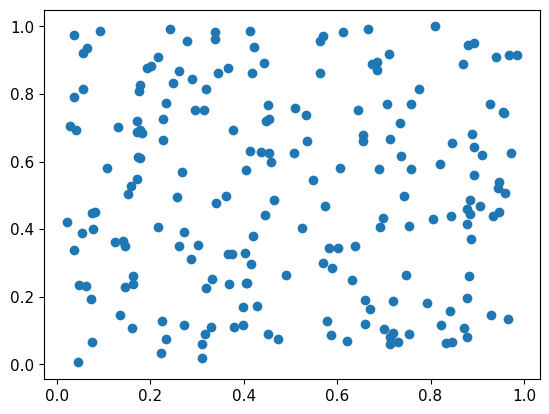

In [7]:
plt.scatter(np.random.rand(200), np.random.rand(200))
plt.show()

In [8]:
opt = '../../config/opt/opt_Visdrone_detect_S_Hyp0.yaml'
with open(opt) as f:
    opt = Namespace(**yaml.safe_load(f))

In [12]:
data = '../../data/coco.yaml'
with open(data) as f:
    opt_data = Namespace(**yaml.safe_load(f))
# (save_dir / 'labels' if opt.save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

# Load model
weights =  "../../runs/train/coco/weights/best.pt"
device = select_device(opt.device, batch_size=opt.batch_size)
model = DetectMultiBackend(weights, device=device, dnn=opt.dnn, data=data, fp16=opt.half)
opt.half &= device.type != 'cpu'  # half precision only supported on CUDA
model.half() if opt.half else model.float()
stride, pt, jit, engine = model.stride, model.pt, model.jit, model.engine
imgsz = check_img_size(opt.imgsz, s=stride)  # check image size
ncm = model.model.nc
task = opt.task if opt.task in ('train', 'val', 'test') else 'val'  # path to train/val/test images

# Data
data = check_dataset(data)  # check
nc = 1 if opt.single_cls else int(opt_data.nc)  # number of classes
# names = {0: 'item'} if opt.single_cls and len(opt_data.names) != 1 else opt_data.names  # class names
# names = model.names if hasattr(model, 'names') else model.module.names  # get class names

# Other
dt = Profile(), Profile(), Profile()  # profiling times
assert ncm == nc, f'{weights} ({ncm} classes) trained on different --data than what you passed ({nc} ' \
                    f'classes). Pass correct combination of --weights and --data that are trained together.'

model.warmup(imgsz=(1 if pt else opt.batch_size, 3, imgsz, imgsz))  # warmup
dataloader = create_dataloader(data[task],
                                imgsz,
                                opt.batch_size,
                                stride,
                                opt.single_cls,
                                workers=opt.workers,
                                prefix=colorstr(f'{task}: '))[0]

YOLOv5 🚀 v6.1-624-ge7533e4 Python-3.10.6 torch-1.12.1 CPU

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
test: Scanning '/Users/louislacombe/CODE/Thesis_code/datasets/coco/test-dev2017.cache' images and labels... 0 found, 20288 missing, 0 empty, 0 corrupt: 100%|██████████| 20288/20288 [00:00<?, ?it/s]


In [17]:
dataloader

In [6]:
opt = '../../config/opt/opt_Visdrone_detect_S_Hyp0.yaml'
with open(opt) as f:
    opt = Namespace(**yaml.safe_load(f))
dataloader, model, opt, device, dt = setup_data_model(opt, ROOT)
num_classes = model.model.nc

data_dict = get_yolo_predictions(dataloader, model, opt, device, dt)
calib_dict, test_dict = split_dict(data_dict, (0.3, 0.7))
print("Length calib dict: ", len(calib_dict), " and length calib dict: ", len(test_dict))

FileNotFoundError: [Errno 2] No such file or directory: '../../../../../Thesis_code/yolov5/data/VisDrone.yaml'

In [ ]:
# Calibration parameters:
n_bins = 50
conf_thres = 0.01
iou_thres_obj = 0.6
iou_thres_class = 0.3

where_apply_calib_obj = "pred"
where_apply_calib_class = "after_nms"

# Choose which calibrator you want to use for the calibration
# calibrator = HistogramBinning(n_bins) # Histogram binning
# calibrator = _SigmoidCalibration() # Platt
calibrator = IsotonicRegression(out_of_bounds="clip") # Isotonic Regression


In [ ]:
print("BEFORE NMS")
calib_location = "pred"
calib_obj = (where_apply_calib_obj == calib_location)
calib_class = (where_apply_calib_class == calib_location)

calibration(
    calib_location,
    calib_obj,
    calib_class,
    calib_dict,
    test_dict,
    calibrator,
    conf_thres,
    iou_thres_obj,
    iou_thres_class,
    dataloader,
    opt,
    num_classes,
    device
)

print("-"*50)
print("-"*50)
print("AFTER NMS")
calib_location = "after_nms"
calib_obj = (where_apply_calib_obj == calib_location)
calib_class = (where_apply_calib_class == calib_location)

calibration(
    calib_location,
    calib_obj,
    calib_class,
    calib_dict,
    test_dict,
    calibrator,
    conf_thres,
    iou_thres_obj,
    iou_thres_class,
    dataloader,
    opt,
    num_classes,
    device
)


In [ ]:
obj_true = []
obj_normal = []
obj_calib = []

for path in test_dict:
    values_ = test_dict[path]
    if "idx" in values_.keys():
        obj_true.extend(values_["pred_obj_y_true"])
        obj_calib.extend(values_["pred_calib_obj_score"])
        obj_normal.extend(values_["pred_obj_score_idx"])


In [ ]:
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(12, 6))
draw_reliability_graph(np.array(obj_normal), np.array(obj_true), n_bins, strategy="uniform", title="Nomal objectness", axs=axs1)
draw_reliability_graph(np.array(obj_calib), np.array(obj_true), n_bins, strategy="uniform", title="Calibrated objectness", axs=axs2)
plt.show()

In [ ]:
# Configure
model.eval()
iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
niou = iouv.numel()

seen = 0
confusion_matrix = ConfusionMatrix(nc=nc)
if isinstance(names, (list, tuple)):  # old format
    names = dict(enumerate(names))
class_map = list(range(1000))
s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
tp, fp, p, r, f1, mp, mr, map50, ap50, map = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
jdict, stats, ap, ap_class = [], [], [], []
